# How to pass runtime values tools

This guide shows how to define tools that depend on dynamically defined variables provided, configuration, graph state, Storage, or other variables. These values are provided by your program, not by the LLM.

Tools can access the [config](https://langchain-ai.github.io/langgraphjs/reference/interfaces/langgraph.LangGraphRunnableConfig.html) for configurable values like user IDs as well as managed values like the [store](https://langchain-ai.github.io/langgraphjs/reference/classes/checkpoint.BaseStore.html).

To inject other arbitrary dependencies, such as graph state, the primary technique is to use [closures](https://developer.mozilla.org/en-US/docs/Web/JavaScript/Closures) to create tools with access to dynamic content. Here's a brief example:

```js
function generateTools(state: typeof StateAnnotation.State) {
  const updateFavoritePets = tool(
    async (input, config) => {
      // Some arguments are populated by the LLM; these are included in the schema below
      const { pets } = input;
      // Others (such as a UserID) are best provided via the config
      // This is set when when invoking or streaming the graph
      const userId = config.configurable?.userId; /
      // LangGraph's managed key-value store is also accessible via the config
      const store = config.store as BaseStore;
      await store.put([userId, "pets"], "names", pets )
      await store.put([userId, "notes"], uuidv4(), {content: state.messages[state.messages.length - 1].content})

      return "update_favorite_pets called.";
    },
    {
      // The LLM "sees" the following schema:
      name: "update_favorite_pets",
      description: "add to the list of favorite pets.",
      schema: z.object({
        pets: z.array(z.string()),
      }),
    }
  );
  return [updateFavoritePets];
}
```

The following examples will elaborate further on these two techniques.

<div class="admonition tip">
    <p class="admonition-title">Prerequisites</p>
    <p>
        This guide is written for those using **tool calling in LangChain**; you can also use tool calling more in LangGraph using your provider SDK without losing any of LangGraph's core features. While this guide will be less applicable, you may consider adapting the general approach of using closures to inject dependencies into tools.
    </p>
</div> 

## Setup

Install the following to run this guide:

```bash
npm install @langchain/langgraph @langchain/openai @langchain/core
```

Next, configure your environment to connect to your model provider.

```bash
export OPENAI_API_KEY=your-api-key
```

Optionally, set your API key for [LangSmith tracing](https://smith.langchain.com/), which will give us best-in-class observability.

```bash
export LANGCHAIN_TRACING_V2="true"
export LANGCHAIN_CALLBACKS_BACKGROUND="true"
export LANGCHAIN_API_KEY=your-api-key
```

## Accessing state

For our first example, we'll want our tool to take graph state as an input, but we don't want the model to try to generate this input when calling the tool. In order to pass runtime values to our tools, we are going to wrap them in a factory function.

## Define the agent state

For this example, the state we will track will just be a list of messages.

In [1]:
import { Annotation } from "@langchain/langgraph";
import { BaseMessage } from "@langchain/core/messages";

const AgentState = Annotation.Root({
  messages: Annotation<BaseMessage[]>({
    reducer: (x, y) => x.concat(y),
  }),
});

const State = AgentState.State;

In [2]:
import { tool } from "@langchain/core/tools";
import { LangGraphRunnableConfig } from "@langchain/langgraph";
import { BaseStore } from "@langchain/langgraph";
import { v4 as uuidv4 } from "uuid";
import { z } from "zod";

function generateTools(state: typeof State) {
  const updateFavoritePets = tool(
    async (input, config: LangGraphRunnableConfig) => {
      // Some arguments are populated by the LLM; these are included in the schema below
      const { pets } = input;
      // Others (such as a UserID) are best provided via the config
      // This is set when when invoking or streaming the graph
      const userId = config.configurable?.userId;
      // LangGraph's managed key-value store is also accessible via the config
      const store = config.store as BaseStore;
      await store.put([userId, "pets"], "names", pets);
      await store.put([userId, "notes"], uuidv4(), {
        content: state.messages[state.messages.length - 1].content,
      });

      return "update_favorite_pets called.";
    },
    {
      // The LLM "sees" the following schema:
      name: "update_favorite_pets",
      description: "add to the list of favorite pets.",
      schema: z.object({
        pets: z.array(z.string()),
      }),
    }
  );
  const getFavoritePets = tool(
    async (_, config: LangGraphRunnableConfig) => {
      const userId = config.configurable?.userId;
      // LangGraph's managed key-value store is also accessible via the config
      const store = config.store as BaseStore;
      const items = await store.search([userId, "pets"]);
      return JSON.stringify(items.map((item) => item.value));
    },
    {
      // The LLM "sees" the following schema:
      name: "get_favorite_pets",
      description: "retrieve the list of favorite pets for the given user.",
      schema: z.object({}),
    }
  );
  return [updateFavoritePets, getFavoritePets];
}


If we look at the tool call schema, which is what is passed to the model for tool-calling, only `pets` is being passed:

In [3]:
import { zodToJsonSchema } from "zod-to-json-schema";

let tools = generateTools({messages: []});

console.log(zodToJsonSchema(tools[0].schema));

{
  type: 'object',
  properties: { pets: { type: 'array', items: [Object] } },
  required: [ 'pets' ],
  additionalProperties: false,
  '$schema': 'http://json-schema.org/draft-07/schema#'
}


## Define the nodes

We now need to define a few different nodes in our graph.

1. The agent: responsible for deciding what (if any) actions to take.
2. A function to invoke tools: if the agent decides to take an action, this node will then execute that action.

We will also need to define some edges.

1. After the agent is called, we should either invoke the tool node or finish.
2. After the tool node have been invoked, it should always go back to the agent to decide what to do next

In [4]:
import {
  END,
  START,
  StateGraph,
  MemorySaver,
  InMemoryStore,
} from "@langchain/langgraph";
import { AIMessage } from "@langchain/core/messages";
import { ToolNode } from "@langchain/langgraph/prebuilt";
import { ChatOpenAI } from "@langchain/openai";

const model = new ChatOpenAI({ model: "gpt-4o" });
const routeMessage = (state: typeof State) => {
  const { messages } = state;
  const lastMessage = messages[messages.length - 1] as AIMessage;
  // If no tools are called, we can finish (respond to the user)
  if (!lastMessage?.tool_calls?.length) {
    return END;
  }
  // Otherwise if there is, we continue and call the tools
  return "tools";
};

const callModel = async (state: typeof State) => {
  const { messages } = state;
  const tools = generateTools(state);
  const modelWithTools = model.bindTools(tools);
  const responseMessage = await modelWithTools.invoke(messages);
  return { messages: [responseMessage] };
};

const toolNodeWithGraphState = async (state: typeof State) => {
  // We fetch the tools any time this node is reached to
  // form a closure and let it access the latest messages
  const tools = generateTools(state);
  const toolNodeWithConfig = new ToolNode(tools);
  return toolNodeWithConfig.invoke(state);
};

const workflow = new StateGraph(AgentState)
  .addNode("agent", callModel)
  .addNode("tools", toolNodeWithGraphState)
  .addEdge(START, "agent")
  .addConditionalEdges("agent", routeMessage)
  .addEdge("tools", "agent");

const memory = new MemorySaver();
const store = new InMemoryStore();

const graph = workflow.compile({ checkpointer: memory, store: store });


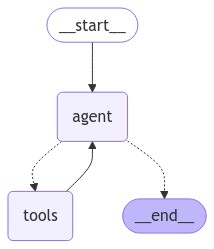

In [7]:
import * as tslab from "tslab";

const graphViz = graph.getGraph();
const image = await graphViz.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

## Use it!

Let's use our graph now!

In [8]:
let inputs = { messages: [{ role: "user", content: "My favorite pet is a terrier." }] };
let config = {
  configurable: {
    thread_id: "1",
    userId: "a-user"
  }
};
let stream = await graph.stream(inputs, {
  ...config
});

for await (
  const chunk of stream
) {
  for (const [node, values] of Object.entries(chunk)) {
    console.log(`Output from node: ${node}`);
    console.log("---");
    console.log(values);
    console.log("\n====\n");
  }
}

Output from node: agent
---
{
  messages: [
    AIMessage {
      "id": "chatcmpl-AFxmlhNJcUlOofixfKzZGc6zjAzBl",
      "content": "",
      "additional_kwargs": {
        "tool_calls": [
          {
            "id": "call_zfqKl3xbD28enfHfa88pDknh",
            "type": "function",
            "function": "[Object]"
          }
        ]
      },
      "response_metadata": {
        "tokenUsage": {
          "completionTokens": 19,
          "promptTokens": 79,
          "totalTokens": 98
        },
        "finish_reason": "tool_calls",
        "system_fingerprint": "fp_2f406b9113"
      },
      "tool_calls": [
        {
          "name": "update_favorite_pets",
          "args": {
            "pets": "[Array]"
          },
          "type": "tool_call",
          "id": "call_zfqKl3xbD28enfHfa88pDknh"
        }
      ],
      "invalid_tool_calls": [],
      "usage_metadata": {
        "input_tokens": 79,
        "output_tokens": 19,
        "total_tokens": 98
      }
    }
  ]
}

===

Let's now verify it can properly cite where it got the information from:

In [9]:
inputs = { messages: [{ role: "user", content: "What's my favorite pets?" }] };
config = {
  configurable: {
    thread_id: "2", // New thread ID, so the conversation history isn't present.
    userId: "a-user"
  }
};

stream = await graph.stream(inputs, {
  ...config
});

for await (
  const chunk of stream
) {
  for (const [node, values] of Object.entries(chunk)) {
    console.log(`Output from node: ${node}`);
    console.log("---");
    console.log(values);
    console.log("\n====\n");
  }
}

Output from node: agent
---
{
  messages: [
    AIMessage {
      "id": "chatcmpl-AFxmpLOnwAAzOTlZ2qJOaqvICnOV0",
      "content": "",
      "additional_kwargs": {
        "tool_calls": [
          {
            "id": "call_q77mTPhqS4GGbC0iDyaK5Ca6",
            "type": "function",
            "function": "[Object]"
          }
        ]
      },
      "response_metadata": {
        "tokenUsage": {
          "completionTokens": 13,
          "promptTokens": 76,
          "totalTokens": 89
        },
        "finish_reason": "tool_calls",
        "system_fingerprint": "fp_2f406b9113"
      },
      "tool_calls": [
        {
          "name": "get_favorite_pets",
          "args": {},
          "type": "tool_call",
          "id": "call_q77mTPhqS4GGbC0iDyaK5Ca6"
        }
      ],
      "invalid_tool_calls": [],
      "usage_metadata": {
        "input_tokens": 76,
        "output_tokens": 13,
        "total_tokens": 89
      }
    }
  ]
}

====

Output from node: tools
---
{
  messages:

As we can see the agent is able to properly cite that the information came from Twitter!